In [1]:
%load_ext autoreload
%autoreload 2

# Имитационное моделирование

В этом ноутбуке исследуем и валидируем имитационную модель, позволяющую рассчитать вероятность идентификации и другие характеристики нашей системы.

In [2]:
from tabulate import tabulate
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
from rfidam.simulation import ModelParams, build_scenario_info
from rfidam.protocol.protocol import LinkProps, Protocol
from rfidam.protocol.symbols import DR, TagEncoding
from rfidam.scenario import parse_scenario
from rfidam.utils import bcolors, get_err, fmt_err, highlight, pluralize

In [4]:
def fmt_header(s):
    return highlight(s, bcolors.OKBLUE)

def fmt_delim(s):
    return highlight(s, bcolors.OKCYAN)

def fmt_float(x):
    return f'{x:.4f}'

In [5]:
LINK_PROPS = LinkProps(
    tari=12.5e-6,
    rtcal=30e-6,
    trcal=35e-6,
    m=TagEncoding.M2,
    dr=DR.DR_643,
    trext=False,
    q=4,
    use_tid=True,
    t_off=0.1)
PROTOCOL = Protocol(LINK_PROPS)

In [6]:
def build_params(scenario: str, ber: float, arrival_interval: float, num_tags: int, time_in_area: float):
    return ModelParams( 
        protocol=PROTOCOL, 
        arrival_interval=arrival_interval,
        time_in_area=time_in_area,
        scenario=parse_scenario(scenario),
        ber=ber
    )

In [7]:
from rfidam.cy_ext.simulation import simulate
# from rfidam.simulation import simulate

def run_sim(params, n_iters = 5):
    journals = [simulate(params, only_id=False) for _ in tqdm(range(n_iters))]
    return journals

In [8]:
BER = .002
ARRIVAL_INTERVAL = .5
TIME_IN_AREA = 2.42

In [9]:
params = build_params("AAA", ber=BER, arrival_interval=ARRIVAL_INTERVAL, num_tags=10000, time_in_area=TIME_IN_AREA)

In [10]:
journals_1 = run_sim(params, n_iters=2)

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
round_infos_x3 = build_scenario_info(journals_1, len(params.scenario) * 3 )

### Build analytic results for the same data


In [12]:
from rfidam.chains import estimate_rounds_props
from rfidam.statistics import count_averages, group_round_values

SCENARIO_MULTIPLIER = 200

rounds_props = estimate_rounds_props(params.scenario*SCENARIO_MULTIPLIER, 
                                     params.protocol, 
                                     ber=BER, 
                                     arrival_interval=ARRIVAL_INTERVAL, 
                                     time_in_area=TIME_IN_AREA)
rounds_props['n_active_tags_stats'] = count_averages(
    group_round_values(
        [p @ np.arange(p.shape[0]) for p in rounds_props['n_active_tags']], 
        len(params.scenario)*3
    ))

### Estimate identification probability

In [13]:
from rfidam.scenario import mark_scenario
from rfidam.chains import estimate_id_probs

marked_scenario = mark_scenario(
    params.scenario*SCENARIO_MULTIPLIER, 
    arrival_interval=ARRIVAL_INTERVAL, 
    time_in_area=TIME_IN_AREA, 
    durations=rounds_props['durations'], 
    t0=50.)

# for i, spec in enumerate(marked_scenario):
#     print(f"{i}: {spec} {' <--- HIT' if spec.n_arrived > 0 else ''}")

avg_id_prob, id_probs_map = estimate_id_probs(
    n_tags_probs=rounds_props['n_active_tags'],
    scenario=marked_scenario,
    durations=rounds_props['durations'],
    ber=BER,
    protocol=PROTOCOL,
    time_in_area=TIME_IN_AREA
)
sim_id_prob = round_infos_x3.id_probs.mean()
print("AVERAGE ID PROB:  ", avg_id_prob)
print("... FROM SIM.  :  ", sim_id_prob, f" (error: {abs(avg_id_prob - sim_id_prob) / sim_id_prob})")
# print("ID PROBS MAPPING: ", id_probs_map)

AVERAGE ID PROB:   0.5789456184246191
... FROM SIM.  :   0.6066513760907845  (error: 0.04566998239532423)


### Visualize

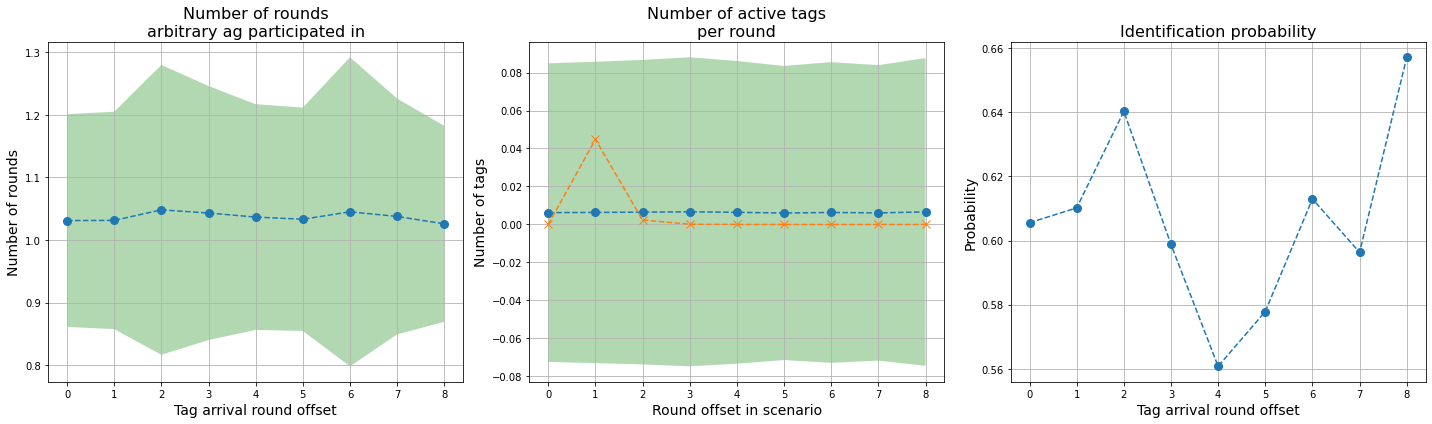

In [14]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=3)
OX = np.arange(round_infos_x3.scenario_length)
axes[0].plot(OX, round_infos_x3.num_rounds_active.means, marker='o', markersize=8, linestyle='--')
axes[0].fill_between(
    OX, 
    round_infos_x3.num_rounds_active.means - round_infos_x3.num_rounds_active.errors, 
    round_infos_x3.num_rounds_active.means + round_infos_x3.num_rounds_active.errors, 
    facecolor='green', alpha=0.3)
axes[0].set_title("Number of rounds\narbitrary ag participated in", fontsize=16)
axes[0].set_xlabel('Tag arrival round offset', fontsize=14)
axes[0].set_ylabel('Number of rounds', fontsize=14)

axes[1].plot(OX, round_infos_x3.num_tags_active.means, marker='o', markersize=8, linestyle='--')
axes[1].plot(OX, rounds_props['n_active_tags_stats'].means, marker='x', markersize=8, linestyle='--')
axes[1].fill_between(
    OX, 
    round_infos_x3.num_tags_active.means - round_infos_x3.num_tags_active.errors, 
    round_infos_x3.num_tags_active.means + round_infos_x3.num_tags_active.errors, 
    facecolor='green', alpha=0.3)
axes[1].set_title("Number of active tags\nper round", fontsize=16)
axes[1].set_xlabel('Round offset in scenario', fontsize=14)
axes[1].set_ylabel('Number of tags', fontsize=14)

axes[2].plot(OX, round_infos_x3.id_probs, marker="o", markersize=8, linestyle='--')
axes[2].set_title('Identification probability', fontsize=16)
axes[2].set_xlabel('Tag arrival round offset', fontsize=14)
axes[2].set_ylabel('Probability', fontsize=14)

for ax in axes:
    ax.grid()

plt.tight_layout()

# Расчет зависимости идентификации от BER

> **TODO: поменять Q, чтобы число меток могло быть сравнимо с числом слотов (или больше)**

> **TODO: добавить сценарии типа AABB, AAAABBBB, Ax, AAx, AAAAAAAAx**

> **TODO: добавить распараллеливание и запись результатов в файл**

In [183]:
bers = np.linspace(0.001, 0.05, 21)
arrival_intervals = [.5, 1., 2.]
time_in_area = 2.42
protocols = {
    "epc": Protocol(LinkProps(tari=12.5e-6, rtcal=30e-6, trcal=35e-6, m=TagEncoding.M2, dr=DR.DR_643, trext=False, q=4, use_tid=False, t_off=0.1)),
    "tid": Protocol(LinkProps(tari=12.5e-6, rtcal=30e-6, trcal=35e-6, m=TagEncoding.M2, dr=DR.DR_643, trext=False, q=4, use_tid=True, t_off=0.1)),
}
scenarios = ["A", "ABABx", "AAABxAAxABABx", "AAAAx", "ABAB"]

In [179]:
if False:
    sim_results = {sc: {interval: {proto: None for proto in protocols} for interval in arrival_intervals} for sc in scenarios}
    ana_results = {sc: {interval: {proto: None for proto in protocols} for interval in arrival_intervals} for sc in scenarios}

In [184]:
from itertools import product

# sim_results["AAAAx"] = {interval: {proto: None for proto in protocols} for interval in arrival_intervals}
# sim_results["ABAB"] = {interval: {proto: None for proto in protocols} for interval in arrival_intervals}

# grid = list(product(["AAAAx", "ABAB"], arrival_intervals, protocols))
grid = list(product(scenarios, arrival_intervals, protocols))
for scenario, arrival_interval, protocol_name in tqdm(grid):
    protocol = protocols[protocol_name]
    print(f"scenario = {scenario}, arrival_interval={arrival_interval}, protocol={protocol}")
    results = []
    for ber in bers:
        params = ModelParams(protocol, arrival_interval, time_in_area=time_in_area, scenario=parse_scenario(scenario), ber=ber)
        journal = simulate(params, only_id=True, n_tags=1000)
        results.append(journal.p_id)
    sim_results[scenario][arrival_interval][protocol_name] = results

  0%|          | 0/12 [00:00<?, ?it/s]

scenario = AAAAx, arrival_interval=0.5, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = AAAAx, arrival_interval=0.5, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55820>
scenario = AAAAx, arrival_interval=1.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = AAAAx, arrival_interval=1.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55820>
scenario = AAAAx, arrival_interval=2.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = AAAAx, arrival_interval=2.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55820>
scenario = ABAB, arrival_interval=0.5, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = ABAB, arrival_interval=0.5, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55820>
scenario = ABAB, arrival_interval=1.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = ABAB, arrival_interval=1.0, p

In [185]:
grid

[('AAAAx', 0.5, 'epc'),
 ('AAAAx', 0.5, 'tid'),
 ('AAAAx', 1.0, 'epc'),
 ('AAAAx', 1.0, 'tid'),
 ('AAAAx', 2.0, 'epc'),
 ('AAAAx', 2.0, 'tid'),
 ('ABAB', 0.5, 'epc'),
 ('ABAB', 0.5, 'tid'),
 ('ABAB', 1.0, 'epc'),
 ('ABAB', 1.0, 'tid'),
 ('ABAB', 2.0, 'epc'),
 ('ABAB', 2.0, 'tid')]

In [186]:
SCENARIO_MULTIPLIER = 1000

ana_results["AAAAx"] = {interval: {proto: None for proto in protocols} for interval in arrival_intervals}
ana_results["ABAB"] = {interval: {proto: None for proto in protocols} for interval in arrival_intervals}

for scenario, arrival_interval, protocol_name in tqdm(grid):
    protocol = protocols[protocol_name]
    print(f"scenario = {scenario}, arrival_interval={arrival_interval}, protocol={protocol}")
    results = []
    for ber in bers:
        extended_scenario = parse_scenario(scenario) * SCENARIO_MULTIPLIER
        
        rounds_props = estimate_rounds_props(
            extended_scenario, 
            protocol, 
            ber=ber, 
            arrival_interval=arrival_interval, 
            time_in_area=time_in_area,
            t0=(100.5 * arrival_interval))

        marked_scenario = mark_scenario(
            extended_scenario, 
            arrival_interval=arrival_interval, 
            time_in_area=time_in_area, 
            durations=rounds_props['durations'],
            t0=(100.5 * arrival_interval))
        
        p_id, _ = estimate_id_probs(
            rounds_props['n_active_tags'], 
            marked_scenario, 
            durations=rounds_props['durations'], 
            ber=ber, 
            protocol=protocol, 
            time_in_area=time_in_area)
        
        results.append(p_id)
    ana_results[scenario][arrival_interval][protocol_name] = results

  0%|          | 0/12 [00:00<?, ?it/s]

scenario = AAAAx, arrival_interval=0.5, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = AAAAx, arrival_interval=0.5, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55820>
scenario = AAAAx, arrival_interval=1.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = AAAAx, arrival_interval=1.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55820>
scenario = AAAAx, arrival_interval=2.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = AAAAx, arrival_interval=2.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55820>
scenario = ABAB, arrival_interval=0.5, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = ABAB, arrival_interval=0.5, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55820>
scenario = ABAB, arrival_interval=1.0, protocol=<rfidam.protocol.protocol.Protocol object at 0x11aa55520>
scenario = ABAB, arrival_interval=1.0, p

In [187]:
from matplotlib.pyplot import get_cmap

CMAP = get_cmap('viridis')

def plot_id_probs(scenario, show_suptitle=False, save=False, fmt="pdf"):
    fig, axes = plt.subplots(figsize=(16, 4), ncols=len(arrival_intervals), nrows=1, sharey=True)
    axes[0].set_ylabel("Вероятность", fontsize=16)
    for i, interval in enumerate(arrival_intervals):
        axes[i].plot(bers, ana_results[scenario][interval]["tid"], linestyle="-", color=CMAP(0.2), 
                     label="TID (аналитика)")
        axes[i].plot(bers, sim_results[scenario][interval]["tid"], linestyle="", marker="v", markersize=6, color=CMAP(0.2),
                     label="TID (симуляция)")
        axes[i].plot(bers, ana_results[scenario][interval]["epc"], linestyle="-", color=CMAP(0.8),
                     label="EPCID (аналитика)")
        axes[i].plot(bers, sim_results[scenario][interval]["epc"], linestyle="", marker="^", markersize=6, color=CMAP(0.8),
                     label="EPCID (симуляция)")
        axes[i].set_title(f"Интервал {interval} сек.", fontsize=18)
        axes[i].tick_params(labelsize=14)
        axes[i].set_xlabel("BER", fontsize=16)
        axes[i].grid()
    axes[2].legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=16, ncol=1)
    if show_suptitle:
        fig.suptitle(f'Вероятность идентификациии для сценария "{scenario}"', fontsize=22)
    plt.tight_layout()
    if save:
        plt.savefig(f"id_prob_{scenario}.{fmt}")

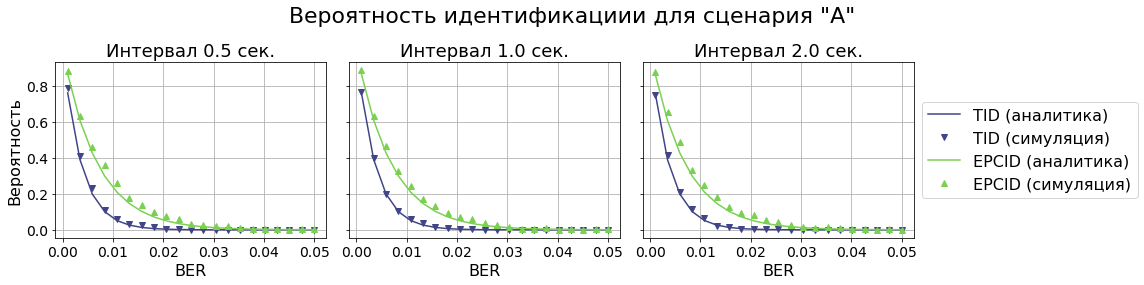

In [188]:
plot_id_probs("A", show_suptitle=True, save=True)

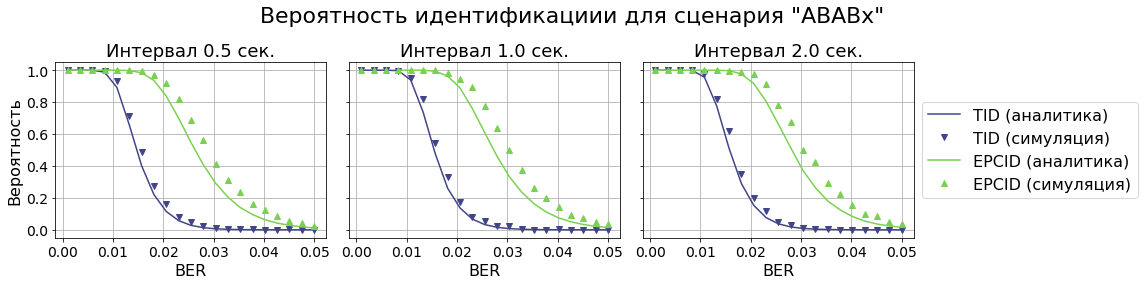

In [189]:
plot_id_probs("ABABx", show_suptitle=True, save=True)

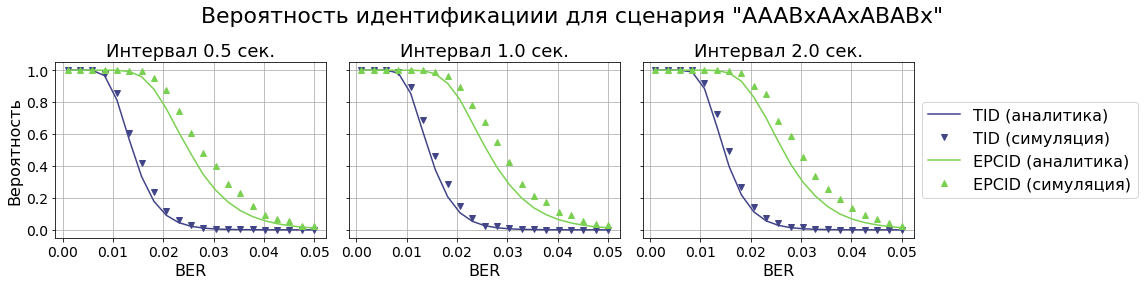

In [190]:
plot_id_probs("AAABxAAxABABx", show_suptitle=True, save=True)

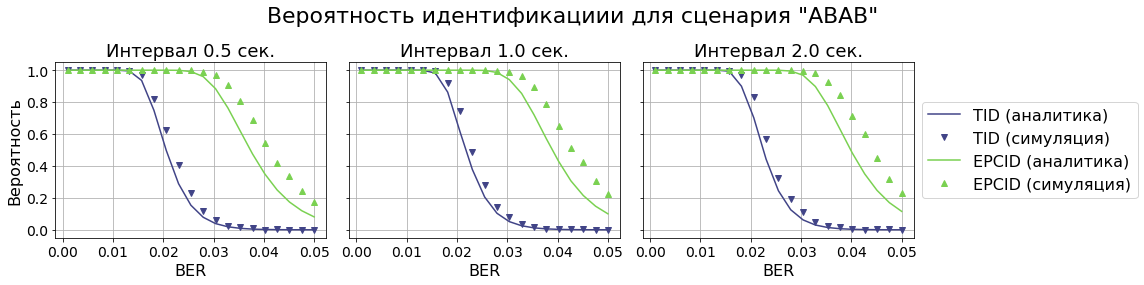

In [191]:
plot_id_probs("ABAB", show_suptitle=True, save=True)

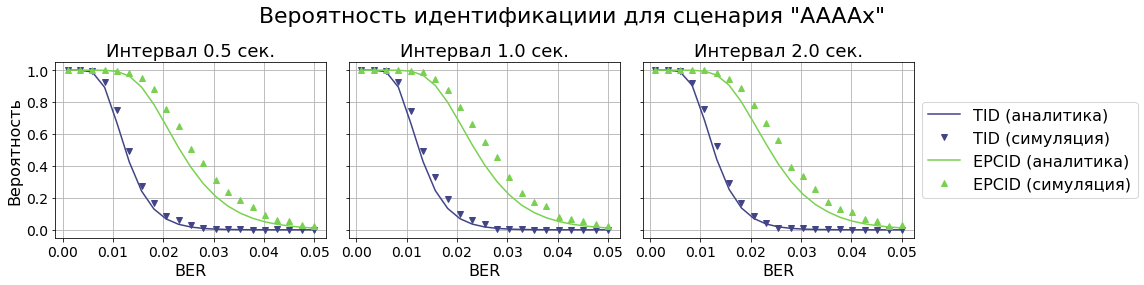

In [192]:
plot_id_probs("AAAAx", show_suptitle=True, save=True)